In [15]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

#-----------------------------------

# Set up your Quantum Register (number of qubits) and,
# Classcial Register (Number of measurement registers to store the result)
qreg = QuantumRegister(8)   # First 4 are for counting, last 4 for 'searching'
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
creg = ClassicalRegister(4)
circ = QuantumCircuit(qreg, creg)

backend = qiskit.BasicAer.get_backend('qasm_simulator')

from qiskit.aqua.circuits.gates.multi_control_toffoli_gate import _cccx

def grover_iteration():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    q = QuantumRegister(4)
    circ = QuantumCircuit(q)
    # Oracle
    circ.h(3)
    _cccx(circ,q)
    circ.x(0)
    _cccx(circ,q)
    circ.x(0)
    circ.x(1)
    _cccx(circ,q)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.h(3)
    # Diffusion Operator
    circ.z(3)
    for qubit in q[:3]:
        circ.h(qubit)
        circ.x(qubit)
    _cccx(circ,q)
    for qubit in q[:3]:
        circ.x(qubit)
        circ.h(qubit)
    circ.z(3)
    return circ

# Create controlled-Grover
grit = grover_iteration().to_gate()
cgrit = grit.control()

def qft(n):
    """n-qubit QFT on q in circ."""
    q = QuantumRegister(n)
    circ = QuantumCircuit(q)
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cu1(math.pi/float(2**(k-j)), q[k], q[j])
    # the Swaps!
    for i in range(int(n/2)):
        circ.swap(q[i], q[n-i-1])
    return circ

qft_dagger = qft(4).to_gate().inverse()

# Initialise all qubits to |+>
for qubit in qreg:
    circ.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in reversed(qreg[:4]):
    for i in range(iterations):
        circ.append(cgrit, qargs=[qubit] + qreg[4:])
    iterations *= 2

# Do inverse QFT on counting qubits
circ.append(qft_dagger, qargs=qreg[:4])

# Measure Qubits
circ.measure(qreg[:4],creg)
#circ.qasm()
#circ.draw(output='mpl')

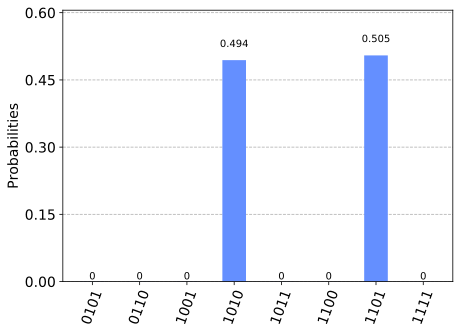

In [16]:
# Execute and see results
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=8192 )
hist = job.result().get_counts()
plot_histogram(hist)


# The following code uses the least busy quantum computer device available on the IBM Cloud.
#qiskit.IBMQ.load_accounts()
#backend = qiskit.providers.ibmq.least_busy(qiskit.IBMQ.backends(simulator=False))
#print("Using the least busy device:",backend.name())
#job = qiskit.execute( circuit, backend )
#print( job.result().get_counts() )

# Output:
# We'll use the least busy device: ibmqx2
# {'1': 1004, '0': 20}
# This means that |1> state was measured 1004 times and,
# |0> state was measured 20 times.

In [17]:
measured_str = max(hist, key=hist.get)

measured_str = max(hist, key=hist.get)[::-1] # Need to reverse the order of bits

measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m-1)))*(2**(-m))
print("Error < %.2f" % err)

Register Output = 11
Theta = 4.31969
No. of Solutions = 4.9
Error < 2.85
